คราวนี้เราจะมาลองสร้าง Dataset ของตัวเอง เพื่อเทรนโมเดล 

* Eczema โรคผิวหนังอักเสบ โรคแพ้ผื่นคัน
* Psoriasis โรคสะเก็ดเงิน
* Acne Vulgaris โรคสิว โรคสิวธรรมดา
* Rosacea โรคผิวหนังอักเสบโรซาเชีย

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล



In [ ]:
folder = 'eczema'
file = 'urls_eczema.txt'

In [ ]:
folder = 'psoriasis'
file = 'urls_psoriasis.txt'

In [ ]:
folder = 'acne'
file = 'urls_acne.txt'

In [4]:
folder = 'rosacea'
file = 'urls_rosacea.txt'

Create folder and download all pictures in urls

In [5]:
path = Path('data/skin')
download_path = path/'downloads'
dest = download_path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
classes = ['eczema','psoriasis','acne', 'rosacea']

In [ ]:
download_images(path/file, dest, max_pics=500)

In [7]:
for c in classes:
    print(c)
    verify_images(download_path/c, delete=True, max_size=500)

eczema


psoriasis


acne


rosacea


# 3. เตรียมข้อมูล

เพิ่มขนาดรูปจาก 224 เป็น 299 และลดขนาด batch size เหลือ 64 เนื่องจากโมเดลที่ขนาดใหญ่ขึ้น มีความต้องการ Memory ที่มากขึ้น ถ้าใช้ Batch Size เท่าเดิมจะทำให้ Error GPU Out of Memory ได้

In [27]:
batchsize = 64
np.random.seed(55)

databunch = ImageDataBunch.from_folder(download_path, train='.', 
                                       valid_pct=0.2, 
                                       ds_tfms=get_transforms(), 
                                       size=320, bs=batchsize).normalize(imagenet_stats)

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ชื่อพันธุ์ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 12 x 9 นิ้ว (figsize)

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [28]:
databunch.classes

['acne', 'eczema', 'psoriasis', 'rosacea']

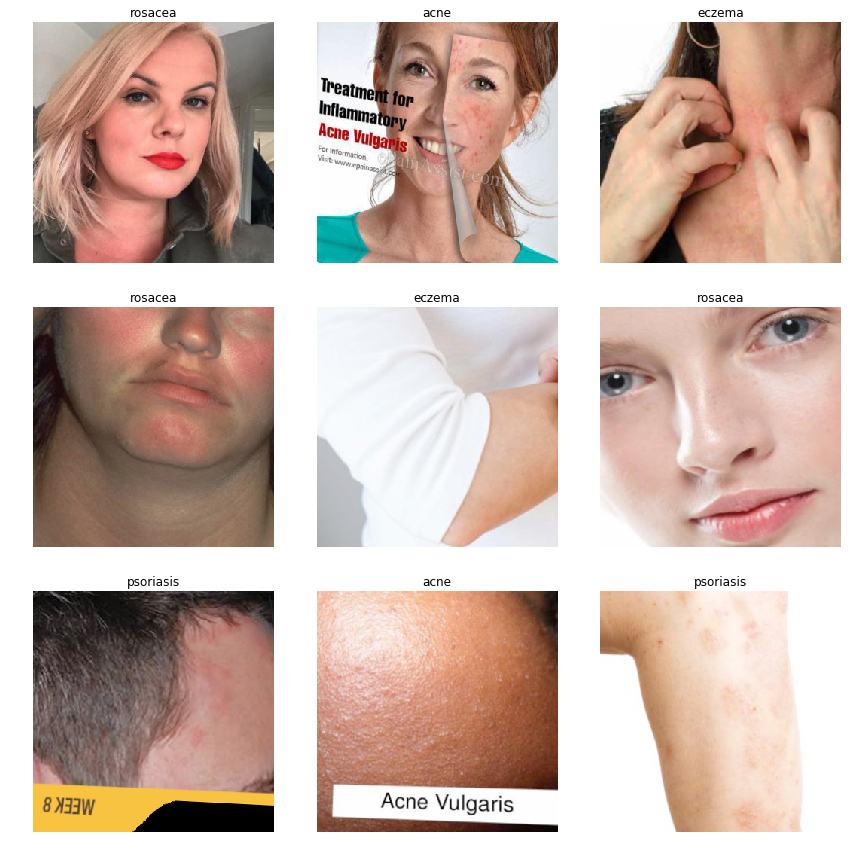

In [29]:
databunch.show_batch(rows=3, figsize=(12, 12))

In [30]:
databunch.classes, databunch.c, len(databunch.train_ds), len(databunch.valid_ds)

(['acne', 'eczema', 'psoriasis', 'rosacea'], 4, 1444, 361)

# 4. สร้างโมเดล

เปลี่ยนจาก models.resnet34 เป็น models.resnet50

In [31]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 8 Cycle

In [32]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,1.300198,0.812967,0.673130,00:25
1,1.082937,0.844359,0.664820,00:16
2,0.927225,0.798715,0.706371,00:16
3,0.833576,0.776585,0.698061,00:17
4,0.763610,0.682946,0.720222,00:17
5,0.687733,0.664389,0.731302,00:17
6,0.610453,0.694354,0.731302,00:16
7,0.553205,0.672527,0.734072,00:17
8,0.506930,0.662017,0.725762,00:16
9,0.463590,0.668111,0.717452,00:17


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [33]:
learner.save('01d-resnet34-1')

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [34]:
# learner.load('resnet50-1')

# 6. เทรนต่อ

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


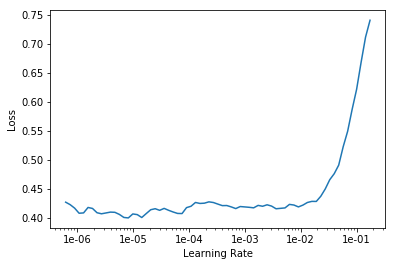

In [35]:
learner.lr_find()
learner.recorder.plot()

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [36]:
learner.unfreeze()
learner.fit_one_cycle(6, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.442728,0.661348,0.720222,00:23
1,0.419722,0.663650,0.747922,00:20
2,0.398514,0.648184,0.731302,00:20
3,0.365984,0.669709,0.745152,00:20
4,0.331051,0.689811,0.731302,00:20
5,0.296145,0.674444,0.747922,00:20
6,0.268194,0.708753,0.742382,00:20
7,0.242880,0.703653,0.734072,00:21
8,0.222118,0.698133,0.722992,00:20
9,0.204178,0.706270,0.725762,00:20


## สำเร็จแล้ว ##

เพียงแค่เวลา 10 นาทีเศษ เราเทรน Model ได้ accuracy ประมาณ 0.95 หรือ ความแม่นยำประมาณ 95%

เปรียบเทียบกับ 94.0% จาก ResNet34 ที่เราเทรนครั้งก่อน 

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [37]:
learner.save('01d-resnet34-2')

# 7. ดูผลลัพธ์

In [38]:
interpretation = ClassificationInterpretation.from_learner(learner)

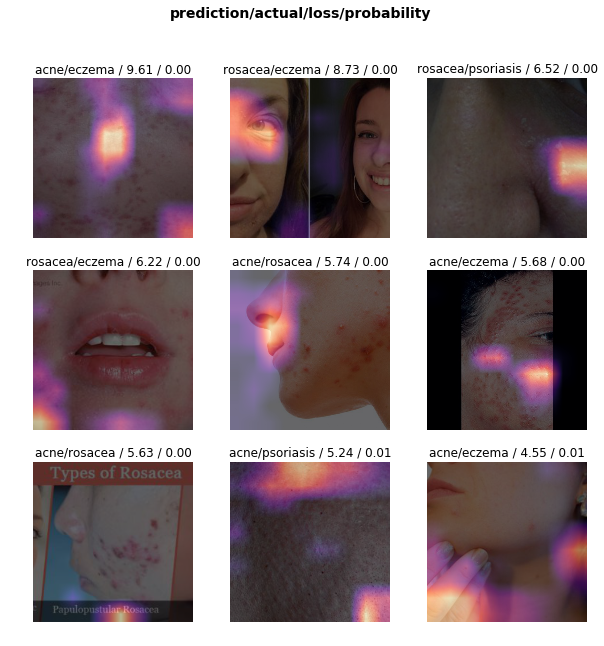

In [43]:
interpretation.plot_top_losses(9, figsize=(10,10))

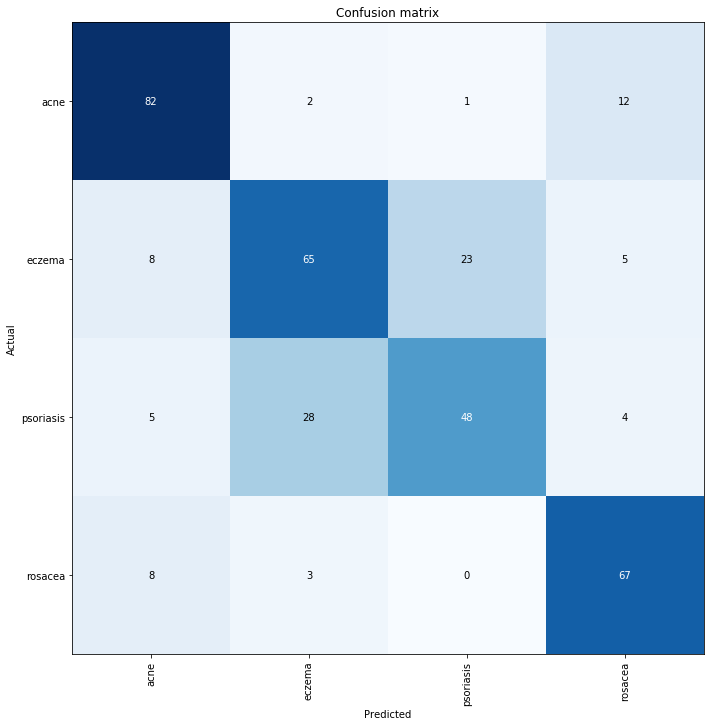

In [45]:
interpretation.plot_confusion_matrix(figsize=(10,10), dpi=72)

เรียกดู most_confused คือ พันธุ์ที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [46]:
interpretation.most_confused(min_val=2)

[('psoriasis', 'eczema', 28),
 ('eczema', 'psoriasis', 23),
 ('acne', 'rosacea', 12),
 ('eczema', 'acne', 8),
 ('rosacea', 'acne', 8),
 ('eczema', 'rosacea', 5),
 ('psoriasis', 'acne', 5),
 ('psoriasis', 'rosacea', 4),
 ('rosacea', 'eczema', 3),
 ('acne', 'eczema', 2)]

Clean ข้อมูล

In [ ]:
from fastai.widgets import *

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)

In [ ]:
ImageCleaner(ds, idxs, path)

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learner, ds_type=DatasetType.Valid)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

# 8. สรุป


เปรียบเทียบกับเคสก่อนที่ใช้ ResNet34 กับ เคสนี้เราใช้ ResNet50 

* โมเดลใช้เวลาในการเทรนนานขึ้น จาก 3 นาที เป็น 10 นาที
* ใช้ memory GPU มากขึ้น 
* ประสิทธิภาพความแม่นยำดีขึ้น ประมาณ 1%

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 1](https://course.fast.ai/videos/?lesson=1)